### KERAS LSTM FORECASTING

A rolling forecast scenario will be used, also called walk-forward model validation.

Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

Then all forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data

In [21]:
import pandas as pd
from pandas import DataFrame, Series
from pandas import concat
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

In [5]:
#df = pd.read_csv('climate_change2013.csv')
cg = pd.read_csv('climate_change2013.csv',index_col='Date',parse_dates = True)
cg.index.freq='MS'

In [6]:
surf_t = cg['surface_temp']
surf_t = surf_t.to_frame()

In [8]:
def scale(train,test,scaler):
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    return scaled_train,scaled_test

def eval(test,predictions):
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [7]:
# TRAIN - TEST SPLITTING
X = surf_t.values
train,test = X[:-12], X[-12:] #the last 12 months (1 year) will be used for the test set

The model forcast i use is the persistent that is a good baseline forecast for a time series with a linear increasing. The persistence forecast is where the observation from the prior time step $(t-1)$ is used to predict the observation at the current time step $(t)$.

I'll take the last observation from the training data and history accumulated by walk-forward validation and using that to predict the current time step. All the predictions will be stored in an array so that they can be directly compared to the test dataset.

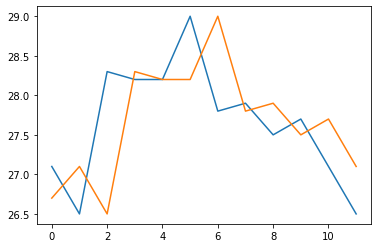

RMSE: 0.752


In [14]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# line plot of observed vs predicted
plt.plot(test)
plt.plot(predictions)
plt.show()

rmse = eval(test,predictions)
print(f'RMSE: {round(rmse,3)}')

-------------------------------------------------------------------------------------

## LSTM

Steps: 
1. Transform the dataset to make it suitable for the LSTM model, including:
    - Transforming the data to a supervised learning problem.
    - Transforming the data to be stationary.
    - Transforming the data so that it has the scale -1 to 1.
2. Fitting a stateful LSTM network model to the training data.
3. Evaluating the static LSTM model on the test data.
4. Report the performance of the forecasts.

#### 1) Transform Time Series to Supervised Learning

The LSTM model in Keras assumes that the data is divided into input (X) and output (y) components so i'll use the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

To do so i'll use the shift() function in Pandas that will push all values in a series down by a specified number places, in this case 1 place that will become the input variables. The time series as it stands will be the output variables.

Then I concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN value will be used in this position. These NaN values will replace with 0 values, which the LSTM model will have to learn as “the start of the series” or “I have no data here,” as a month with zero observation.

In [25]:
def timeseries_to_supervised(data, lag=1):
    '''
    Function that takes in input:
    - numpy array of the raw time series data 
    - the number of shifted series to create and use as inputs (lag)

    It returns a dataframe '''

    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		# the first observation in the series is skipped as there is no prior observation with which to calculate a differenced value.
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	'''
	Functions that takes in input:

	and invert the differenciating process in order to take forecasts made on the differenced 
	series back into their original scale.
	'''
	return yhat + history[-interval]

def scale(train, test):
	'''
	Function that takes in input:
	- train dataset
	- test dataset

	and scale them to [-1, 1]. It returns the type of scaler used, the train and the test scaled.
	'''
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
def invert_scale(scaler, X, value):
	'''
	Function that takes in input:
	-
	-
	- the forecasted value

	and performs an inverse scaling for the given forecasted value.
	'''

	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	'''
	Function that takes in input:
	- the trainset
	- the batch size
	- the number of epochs
	- 
	
	and applies the defined model to the data and return it.	
	'''
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
def forecast_lstm(model, batch_size, X):
	'''
	Function that takes in input:
	- the model fitted
	- the number of batch's size
	- the values

	and makes a one step forecast. It returns the forecasted values
	'''
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [31]:
# transform data to be stationary
raw_values = surf_t.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 10, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.06298254],
       [-0.15727933],
       [-0.2145258 ],
       [-0.2464304 ],
       [-0.34049383],
       [-0.41099796],
       [-0.42716855],
       [-0.3882243 ],
       [-0.36370608],
       [-0.27744997],
       [-0.18570736],
       [-0.02675941],
       [ 0.08605   ],
       [ 0.11031339],
       [ 0.12329526],
       [ 0.12307367],
       [ 0.16982839],
       [ 0.18151341],
       [ 0.20635034],
       [ 0.18812904],
       [ 0.19976138],
       [ 0.17039362],
       [ 0.17574868],
       [ 0.19725859],
       [ 0.18622491],
       [ 0.15455191],
       [ 0.09188451],
       [ 0.00387527],
       [-0.06602155],
       [-0.14550605],
       [-0.19541477],
       [-0.2596403 ],
       [-0.26540947],
       [-0.31941774],
       [-0.27505767],
       [-0.21309273],
       [-0.1991754 ],
       [-0.18991701],
       [-0.16540729],
       [-0.15556428],
       [-0.15897995],
       [-0.15233368],
       [-0.05830929],
       [-0.03752878],
       [ 0.03632954],
       [ 0

In order to develop a robust result, i fix a number seed used by Keras to ensure the results are reproducible. So i can repeat the experiment from the previous section multiple times, then take the average RMSE as an indication of how well the configuration would be expected to perform on unseen data on average.

To do it i wrap the model fitting and walk-forward validation in a loop of fixed number of repeats (30). Each iteration the RMSE of the run can be recorded and use to summarize the distribution of RMSE scores.

Month=1, Predicted=26.725220, Expected=27.100000
Month=2, Predicted=27.130646, Expected=26.500000
Month=3, Predicted=26.536179, Expected=28.300000
Month=4, Predicted=28.307419, Expected=28.200000
Month=5, Predicted=28.173253, Expected=28.200000
Month=6, Predicted=28.160275, Expected=29.000000
Month=7, Predicted=28.938545, Expected=27.800000
Month=8, Predicted=27.753007, Expected=27.900000
Month=9, Predicted=27.869712, Expected=27.500000
Month=10, Predicted=27.486721, Expected=27.700000
Month=11, Predicted=27.696826, Expected=27.100000
Month=12, Predicted=27.110934, Expected=26.500000
Test RMSE: 0.741
Month=1, Predicted=27.127657, Expected=27.100000
Month=2, Predicted=27.517996, Expected=26.500000
Month=3, Predicted=26.977766, Expected=28.300000
Month=4, Predicted=28.684065, Expected=28.200000
Month=5, Predicted=28.543104, Expected=28.200000
Month=6, Predicted=28.492441, Expected=29.000000
Month=7, Predicted=29.192291, Expected=27.800000
Month=8, Predicted=28.116343, Expected=27.900000


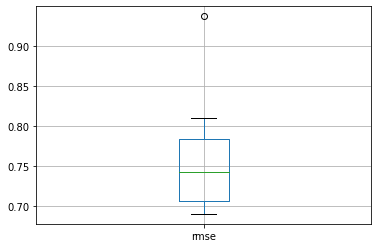

In [32]:
# repeat experiment
repeats = 10
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 10, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)	
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X) #yhat = y
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
		expected = raw_values[len(train) + i + 1]
		print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
	
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('Test RMSE: %.3f' % rmse)
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.show()

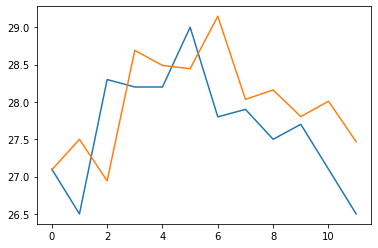

In [33]:
# line plot of observed vs predicted
plt.plot(raw_values[-12:])
plt.plot(predictions)
plt.show()

### 2) Transform Time Series to Stationary

A dataset non stationary implies the presence of a structure in the data that is dependent on the time, so there is an increasing trend in the data. I need to make this data stationary because it's easy to model.

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data (like i already did for the VARMA model)
